In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib import animation
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [6]:
class SAW():
    """
    The eponymous self-avoiding walker. This class will create an instance
    of a random walker that knows how not to walk on a space it has walked on
    before.
    self.size should be selected carefully - there is no edge case management.
    """
    def __init__(self,N=50):
        # cardinal: 0 = down, 1 = left, 2 = up, 3 = right
        self.N = N
        self.size = 129 # I chose this because the odds of a walk exceeding 50 steps are slim
        self.grid = np.zeros((self.size,self.size))
        self.half = self.size//2
        self.center = np.array([self.half,self.half])
        self.grid[self.half,self.half] = 1
        self.grid[self.half-1,self.half] = 1
        self.direction = 2
        self.position = [self.half-1,self.half]
        self.weight = 1
        self.k = 0
        
    def reset(self):
        """
        Sets important member variables to the initial state.
        """
        self.grid = np.zeros((self.size,self.size))
        self.grid[self.half,self.half] = 1
        self.grid[self.half-1,self.half] = 1
        self.direction = 2
        self.position = [self.half-1,self.half]
        self.weight = 1
        self.k = 0
        
    def step(self):
        """
        Basic random step. If it runs into itself it stops the walk.
        """
        step_direction = (np.random.randint(1,4) + self.direction - 2)%4
        proposed_position = [self.position[0]+(1-step_direction)*(step_direction%2==0),\
                             self.position[1]+(step_direction-2)*(step_direction%2!=0)]
        # 0: [i+1][j]; 1: [i][j-1]; 2: [i-1][j]; 3: [i][j+1]
        if self.grid[proposed_position[0],proposed_position[1]] != 0:
            self.weight = 0
            return 0
        else:
            self.k += 1
            self.grid[proposed_position[0],proposed_position[1]] = self.k
            self.position = proposed_position
            self.direction = step_direction
            return 1
    
    def weighted_step(self):
        """
        Rosenbluth-Rosenbluth weighted self-avoiding step. If it traps itself
        it stops the walk.
        """
        i,j = self.position
        open_sites = [coord for coord in [[i+1,j],[i-1,j],[i,j+1],[i,j-1]] if self.grid[coord[0],coord[1]] == 0]
        Sn = len(open_sites)
        
        if Sn == 0: # if there are no steps available, return 0
            self.weight = 0
            return 0
        
        self.weight *= Sn/3
        
        new_position = open_sites[np.random.randint(0,Sn)]
        diff = [self.position[0]-new_position[0],self.position[1]-new_position[1]]
        self.direction = (1-diff[0])*(diff[1]==0)+(2+diff[1])*(diff[0]==0)
        self.position = new_position
        self.k += 1
        self.grid[self.position[0],self.position[1]] = self.k
        return 1
            
    def walk(self,step_method):
        """
        Takes either self.weighted_step or self.step as argument, then goes
        on a walk with that step method.
        """
        is_walking = 1
        while is_walking == 1 and self.k < self.N:
            is_walking = step_method()
        return 1 if self.k == self.N else 0

In [15]:
def walker_stats(N=10):
    """
    Takes 1000 walkers for N steps. The step method must be selected manually.
    
    """
    successes = 0
    number_of_walkers = 1000
    success_array = np.zeros((number_of_walkers,2))
    fail_array = np.zeros((number_of_walkers,2))
    both_array = np.zeros((number_of_walkers,2))

    for i in range(number_of_walkers):
        walker = SAW(N)
        if walker.walk(walker.weighted_step):       #!!! SELECT STEP METHOD HERE !!!
            successes += 1
            success_array[i] = [walker.weight,np.sum(np.square(np.array(walker.position)-walker.center))]
        else:
            fail_array[i] = [walker.weight,np.sum(np.square(np.array(walker.position)-walker.center))]
        both_array[i] = [walker.weight,np.sum(np.square(np.array(walker.position)-walker.center))]
    success_rate = successes/number_of_walkers*100
    
    # if the weighted step method was used
    if np.abs((np.sum(both_array[:,0])+1)/number_of_walkers - 1) > 1e-8: 
        success_norm = success_array[:,0]@success_array[:,1]/np.sum(success_array[:,0])
        both_norm = both_array[:,0]@both_array[:,1]/np.sum(both_array[:,0])
        fail_norm = fail_array[:,0]@fail_array[:,1]/np.sum(fail_array[:,0]) if np.sum(fail_array[:,0])>0 else 0
    # else the unweighted step method was used
    else:
        success_norm = np.sum(success_array[:,1])/number_of_walkers
        fail_norm = np.sum(fail_array[:,1])/number_of_walkers
        both_norm = np.sum(both_array[:,1])/number_of_walkers
        
    return success_rate, success_norm, fail_norm, both_norm, both_array
    
def iterate_and_plot():
    """
    Ranges number of steps N and interprets the relationships between N
    and the mean square radius.
    """
    step_numbers = np.arange(4,32)
    success_rates = []
    success_norms = []
    fail_norms = []
    both_norms = []
    
    for n in step_numbers:
        success_rate,success_norm,fail_norm,both_norm,both_array = walker_stats(n)
        success_rates.append(success_rate)
        success_norms.append(success_norm)
        fail_norms.append(fail_norm)
        both_norms.append(both_norm)
        
    plt.plot(step_numbers,success_rates)
    plt.title("Success Rate vs Number of Steps")
    plt.xlabel("number of steps (N)")
    plt.ylabel("success rate %")
    plt.show()
    
    l1,l2,l3 = plt.plot(step_numbers,success_norms,'-g',step_numbers,fail_norms,'-y',step_numbers,both_norms,'-.r')
    plt.legend((l1,l2,l3),('success','fail','both'))
    plt.title("Mean Square Distance vs Number of Steps")
    plt.xlabel("number of steps (N)")
    plt.ylabel("mean square distance")
    plt.show()
    
    fit = linregress(np.log10(step_numbers),np.log10(both_norms))
    x_fit = np.log10(step_numbers)
    y_fit = fit.slope*x_fit+fit.intercept
    plt.plot(np.log10(step_numbers),np.log10(both_norms),'ok',x_fit,y_fit,'-r')
    plt.title('nu: %f' % fit.slope)
    plt.xlabel("log10(number of steps)")
    plt.ylabel("log10(mean square distance)")
    plt.show()
    
    plt.plot(both_array[:,0],both_array[:,1],'ok')
    plt.title("Mean Square Distance vs Weight")
    plt.xlabel("weight")
    plt.ylabel("mean square distance")
    plt.show()

In [16]:
def make_a_movie():
    """
    Generates two MP4 movies. The first is with the weighted step method, the
    second is with the unweighted step method. There is some waste here in that
    we create more walks than we animate, but the waste is negligible compared
    to the amount of time it takes to save the animation as MP4.
    """
    
    def animate_weighted(i,walker,im):
        # helper function for make_a_movie
        walker.weighted_step()
        if walker.weight == 0 or walker.k >= walker.N:
            walker.reset()
        im.set_array(np.where(walker.grid>0,1,0))
        return im,
    
    def animate_unweighted(i,walker,im):
        # helper function for make_a_movie
        walker.step()
        if walker.weight == 0 or walker.k >= walker.N:
            walker.reset()
        im.set_array(np.where(walker.grid>0,1,0))
        return im,
    
    fig = plt.figure(figsize=(10,10))
    plt.tick_params(which='both',length=0,width=0,labelbottom=False,labelleft=False)
    plt.tight_layout()
    number_of_walkers = 20
    N = 100
    
    walker = SAW(N)
    im = plt.imshow(np.where(walker.grid>0,1,0),vmin=-0.3,vmax=1.5,cmap='hot')
    
    i = 0
    while i < number_of_walkers:
        anim = animation.FuncAnimation(fig, animate_weighted, fargs=(walker,im),save_count = 1000)
        i += 1
    
    f = r'weighted_step.mp4'
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=30,bitrate=1800)
    anim.save(f, writer=writer)
    
    im = plt.imshow(np.where(walker.grid>0,1,0),vmin=-0.3,vmax=1.5,cmap='hot')
    
    i = 0
    while i < number_of_walkers:
        anim = animation.FuncAnimation(fig, animate_unweighted, fargs=(walker,im),save_count = 1000)
        i += 1
    
    f = r'unweighted_step.mp4'
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=30,bitrate=1800)
    anim.save(f, writer=writer)

In [17]:
def layered_plot(N=100):
    """
    Takes as input the limit N on the number of steps a walker can take.
    Produces a plot of each walk taken.
    """
    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys',
             'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 
             'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu',
             'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn', 'binary', 'gist_yarg',
             'gist_gray', 'gray', 'bone', 'pink', 'spring', 'summer', 'autumn',
             'winter', 'cool', 'Wistia', 'hot', 'afmhot', 'gist_heat',
             'copper', 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
             'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic',
             'twilight', 'twilight_shifted', 'hsv', 'Pastel1', 'Pastel2',
             'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10',
             'tab20', 'tab20b', 'tab20c', 'flag', 'prism', 'ocean',
             'gist_earth', 'terrain', 'gist_stern', 'gnuplot', 'gnuplot2',
             'CMRmap', 'cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet',
             'turbo', 'nipy_spectral', 'gist_ncar']
    
    fig = plt.figure(figsize=(10,10))
    plt.tick_params(which='both',length=0,width=0,labelbottom=False,labelleft=False)
    plt.tight_layout()
    
    number_of_walkers = 200
    output_array = []
    im = [None] * number_of_walkers
    
    ## necessary bits to make gridpoint = 0 transparent
    # base colormap
    cmap = plt.get_cmap(cmaps[np.random.randint(len(cmaps))])
    #cmap = cm.jet
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,-1] = np.linspace(0,1,cmap.N)
    my_cmap = ListedColormap(my_cmap)
    my_cmap.set_under('k',alpha=0)
    
    # alpha value gradient for walks
    alpha_vals = np.linspace(0.3,1,number_of_walkers,endpoint=True)
    
    for i in range(number_of_walkers):
        walker = SAW(N)
        walker.walk(walker.weighted_step)
        output_array.append(walker.grid)
        
    for i in range(number_of_walkers):
        im[-i] = plt.imshow(output_array[i],cmap=my_cmap, alpha=alpha_vals[i])
    plt.show()

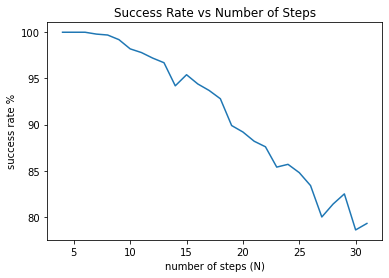

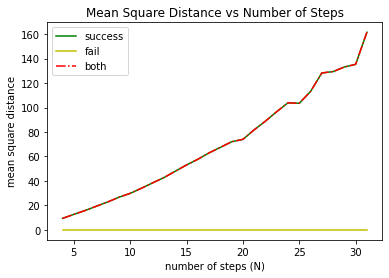

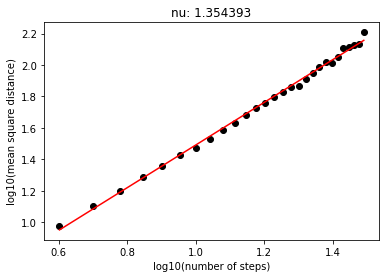

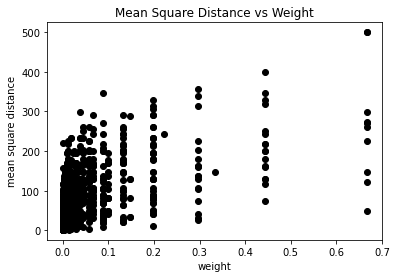

In [18]:
iterate_and_plot()

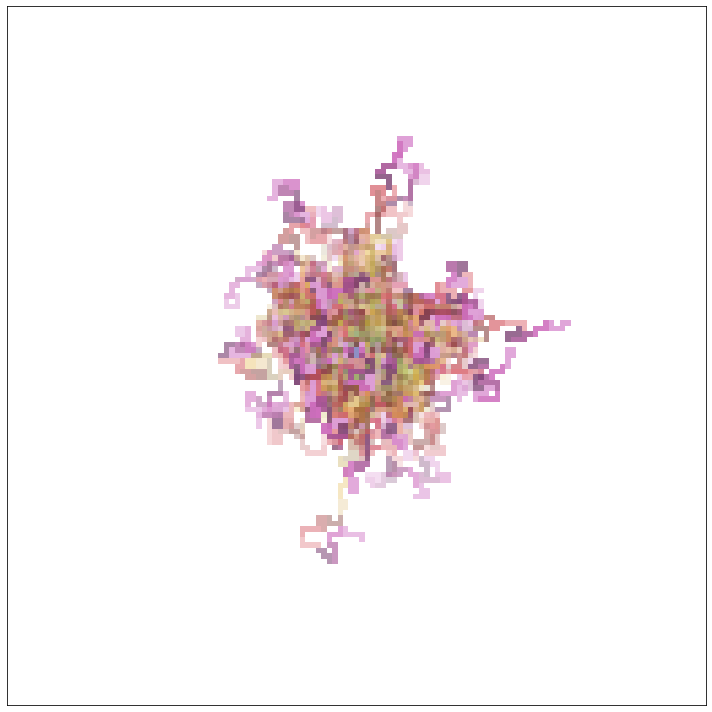

In [19]:
layered_plot()